In [98]:
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline
import os
from os.path import join

import keras
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Conv2D, Input, Reshape, concatenate, MaxPooling2D,Dropout, Flatten, 
RepeatVector, UpSampling2D, Conv1D, Permute, BatchNormalization, Activation, 
                          UpSampling2D, MaxPooling1D, GlobalAveragePooling1D, Embedding)
from keras import Model
from keras.engine.topology import Layer, InputSpec
from keras import backend as K
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import mean_squared_error
from keras.preprocessing import sequence

from Vocabulary import Vocabulary
from keras.backend import clear_session

clear_session()

In [102]:
datasets = ['android', 'ios', 'web']
BACKEND = datasets[0]
traindir = "{}/training_features".format(BACKEND)
vocab_path = '../pix2code/bin/{}/'.format(BACKEND)

# Load Data (tokens, images)

In [78]:
def process_string(data_dir, file):
    """Turns the gui descriptor files into a list of their 'words'"""
    f = open(join(data_dir, file))
    list_words = f.read().split()
    new_list = []
    for word in list_words:
        # Remove special characters
        special_characters = " ,\n"
        for c in special_characters:
            word = word.replace(c, '')
        new_list.append(word)
    return new_list

def load_data(data_dir):
    """Loads in the sentence and image data together.
    Returns (sentences, images)"""
    images = []
    sentences = []
    files = os.listdir(data_dir)
    for listing in files:
        # Load the sentence files, then the images
        # There are less likely to be user-made files in this dir that end with .gui
        if listing.endswith('.gui'):
            base = listing[:-4]
            try:
                img_f = join(data_dir, base + '.npz')
                img = np.load(img_f)['features']
            except Exception as e:
                print(e)
                print("Error trying to match img for {}".format(listing))
                continue
            sent = process_string(data_dir, listing)
            sentences.append(sent)
            images.append(img)
    return sentences, np.array(images)

sentences, GUIS = load_data(traindir)
assert len(sentences) == len(GUIS) and len(sentences) == 1500
print("Loaded succesfully")

Loaded succesfully


# One Hot

Here we are drawing on files and a class from pix2code training. This Vocabulary class is from `pix2code/model/classes/Vocabulary.py`

In [9]:
voc = Vocabulary()
voc.retrieve(vocab_path)
VOCAB_SIZE = len(voc.binary_vocabulary)

In [79]:
#Find max seq length
max_length = 0
for j in range(len(sentences)):
    if len(sentences) > max_length:
        max_length = len(sentences)

def to_hot(sentences, max_length, voc):
    hot = np.zeros((len(sentences), max_length, len(voc.binary_vocabulary)))
    for i, sent in enumerate(sentences):
        for j, word in enumerate(sent):
            hot[i, j] = voc.binary_vocabulary[word]
    return hot
hot = to_hot(sentences, max_length, voc)
assert len(hot) == 1500
print("Converted to one-hot succesfully")

Converted to one-hot succesfully


# Word2Vec Model - For fine tuned embeddings
---

Embedding the DSL sentence representation into condensed, semantically-infused vector representations. *Currently unused.*

In [38]:
#All word embeddings (size of training set x sentence length x 100(embedding dimension))
def create_wordembeddings(sentences, EMBED_SIZE):
    """Creates a Word2Vec model to compress the sentence data.
    Returns a np.array of (#sentences, sentence length, EMBED_SIZE)"""
    from gensim.models import Word2Vec
    
    model = Word2Vec(sentences, min_count=1,size=EMBED_SIZE)
    words = list(model.wv.vocab)
    
    wordembeddings = []
    for sentence in sentences:
        result_array = np.empty((0, EMBED_SIZE))
        for word in sentence:
            result = model[word].reshape(1, EMBED_SIZE)
            result_array = np.append(result_array, result, axis=0)
        result_array = np.pad(result_array, ((max_length - result_array.shape[0],0), (0,0)), 'constant', constant_values = 0)
        wordembeddings.append(result_array)
    wordembeddings = np.array(wordembeddings)
    return wordembeddings

wordembeddings = create_wordembeddings(sentences, VOCAB_SIZE)
assert wordembeddings.shape[0] == 1500

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Extra Model Parts

Currently unused. Used in previous iterations to repeat 3D embedding data. For example repeating a (16, 16, 16) embedding.

In [13]:
#Custom Layer to get from 3D -> 4D
class RepeatVector4D(Layer):
    def __init__(self, n, **kwargs):
        self.n = n
        self.input_spec = [InputSpec(ndim=3)]
        super(RepeatVector4D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.n, input_shape[1], input_shape[2])
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n, input_shape[1], input_shape[2])

    def call(self, x, mask=None):
        x = K.expand_dims(x, 1)
        pattern = K.stack([1, self.n, 1, 1])
        return K.tile(x, pattern)

# Model Design

Functions that help the model design process.

In [101]:
def load_frozen(model_path, freeze=False):
    model = keras.models.load_model(model_path)
    for layer in model.layers:
        layer.trainable = False if freeze else True
    return model

def unroll_v0(model, prev):
    """Ties the decoder portion of the autoencoder-v0 models from another notebook."""
    for layer in model.layers[5:]:
        prev = layer(prev)
    return prev

def unroll_v1(model, prev):
    """Ties the decoder portion of the autoencoder-v1 models from another notebook."""
    count = 0
    for layer in model.layers[-10:]:
        prev = layer(prev)
    return prev

def make_callback(model, dataset):
    """Creates a lambda callback that plots the models prediction on the first 20 pictures of the dataset."""
    def callback(epoch, logs):
        gif_range(model, dataset, start=0, stop=20)
    return keras.callbacks.LambdaCallback(on_epoch_end=callback)

def shuffle_weights(model, weights=None):
    """
    @author: jklient
    @source: https://github.com/keras-team/keras/issues/341

    Randomly permute the weights in `model`, or the given `weights`.

    This is a fast approximation of re-initializing the weights of a model.

    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).

    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)
    
def gif_range(model, data, start=0, stop=1, save=True):
    """
    Adapted from - 
    @author: Eli Bendersky
    @source: https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/
    Makes a GIF that reveals the model's predictions for the first (stop-start) images in data.
    Saves the GIF to `dsl_predictions.gif`
    """
    import sys
    from matplotlib.animation import FuncAnimation

    fig, ax = plt.subplots()
    #   fig.set_tight_layout(True)

    # Query the figure's on-screen size and DPI. Note that when saving the figure to
    # a file, we need to provide a DPI for that separately.
    #   print('fig size: {0} DPI, size in inches {1}'.format(
    #       fig.get_dpi(), fig.get_size_inches()))
    
    ax.set_xticks([])
    ax.set_yticks([])
        
    def update(i):
        label = 'wordembedding {0}'.format(i)
        # print(label)
        ax.imshow(model.predict(np.expand_dims(data[i], axis=0))[0])
        ax.set_xlabel(label)
        return ax
    
    fig.tight_layout()
    anim = FuncAnimation(fig, update, frames=np.arange(start, stop), interval=70)
    if save:
        anim.save('dsl_predictions.gif', dpi=80, writer='imagemagick')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()
    plt.close(fig)
    
def make_model_old(encoder_path, lstm_decoder_path, autoencoder_path='model/autoencoders-v0/ios.h5'):
    """A deprecated iteration of the dsl2pix model design."""
    # Freeze the pretrained encoder & decoder (respectively)
    pix2code_lstm = load_frozen(encoder_path, False)
    autoencoder = load_frozen(autoencoder_path, False)

    x_in = Input(shape = (max_length, VOCAB_SIZE), name = 'x_in')
    x_flatten = Flatten()(x_in)
    last = Dense(912, activation='relu')(x_flatten)
    drop_rate = 0.1
    last = Dropout(drop_rate)(last)
    #y_lstm = LSTM(128, return_sequences = True, input_shape=(max_length, 100))(y_in)
    
    b1 = Dense(48*48, activation='relu')(x_flatten)
    b1 = Reshape((48, 48, 1))(b1)
    b1 = Conv2D(filters=64, kernel_size=(3,3), strides=(3,3), padding='valid', 
                activation='relu', name='b1conv_1')(b1)
    b1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='relu')(b1)
    last = Reshape((48, 19))(last) # Input size of pix2code's first encoder
    last = LSTM(19, return_sequences=True)(last)
    last = LSTM(19, return_sequences=True)(last)
    last = pix2code_lstm(last)
    last = LSTM(128, return_sequences = True)(last)
    last = LSTM(256, return_sequences = True)(last)
    last = Dropout(drop_rate)(last)
    last = LSTM(512, return_sequences = False)(last)
    reshape = Reshape((8,8,8))(last)
    last = UpSampling2D((2,2), name='upsampler-trainable')(reshape)
    last = Conv2D(32, kernel_size=(4,4), padding='same', activation='relu')(last)
#     last = Dropout(drop_rate)(last)
    last = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(last)
    last = Reshape((16,16,16))(last)
    
    # Load in the v0 autoencoder
    last = keras.layers.Add()([b1, last])
    last = Conv2D(16, kernel_size=(2,2), padding='same',activation='relu')(last)
    last = unroll_v1(autoencoder, last)
    
    model = Model(x_in, last)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    return model

def unroll_hydra(model, last):
    return model.layers[-1](last)

In [100]:
def make_conv(autoencoder_path):
    """1D conv model :/"""
    x_in = Input(shape=(max_length, VOCAB_SIZE))
    last = Conv1D(64, 7, padding='same', activation='relu')(x_in)
    last = MaxPooling1D()(last)
    last = Conv1D(64, 5, padding='same', activation='relu')(last)
    last = Conv1D(128, 4, padding='same', activation='relu')(last)
    last = MaxPooling1D()(last)
    last = Flatten()(last)
    last = Dense(1024, activation='relu')(last)
    autoencoder = load_frozen(autoencoder_path, freeze=False)
    last = Reshape((8, 8, 16))(last)
    last = UpSampling2D()(last)
    last = unroll_hydra(autoencoder, last)
    model = Model(x_in, last)
    model.compile(RMSprop(lr=0.01), loss='binary_crossentropy')
    return model


clear_session()
model = make_conv('ios-hydra-model')
# Uncomment to see the number of model parameters
# model.summary()
val_plot = make_callback(model, hot[1400:])
early_stop = EarlyStopping(monitor='val_loss', patience=7)
model.fit(hot[:1400], GUIS[:1400], callbacks=[val_plot, early_stop],
          validation_data=(hot[1400:], GUIS[1400:]),epochs=65, batch_size=32, shuffle=False)

Train on 1400 samples, validate on 100 samples
Epoch 1/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.2345 - val_loss: 0.1793
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 2/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1733 - val_loss: 0.1628
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 3/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1652 - val_loss: 0.1603
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 4/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1605 - val_loss: 0.1548
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 5/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1579 - val_loss: 0.1543
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 6/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1553 - val_loss: 0.1505
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 7/65
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1536 

In [105]:
model.save('dsl2pix-{}'.format(BACKEND))

# Visualizing Results

gui descriptor:	 stack { row { label switch } row { label btn-add } row { img img img } row { label switch } row { label btn-add } row { label slider label } row { label slider label } row { label btn-add } } footer { btn-download btn-download btn-more }
Counter({'{': 10, '}': 10, 'label': 9, 'row': 8, 'btn-add': 3, 'img': 3, 'switch': 2, 'slider': 2, 'btn-download': 2, 'stack': 1, 'footer': 1, 'btn-more': 1})


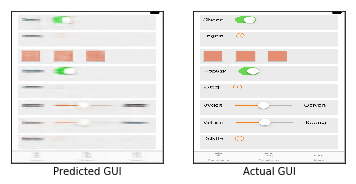

In [96]:
from collections import Counter

def compare(sentences, hot, pics, idx):
    """Compares the results of the model.

    Displays the input to the model, output of the model on the input, and ground truth.
    Input to the model is chosen as the hot[idx].
    """
    fig, axes = plt.subplots(1, 2)
    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])
    
    axes[0].imshow(model.predict(np.expand_dims(hot[idx], 0))[0])
    axes[0].set_xlabel("Predicted GUI")
    axes[1].imshow(pics[idx])
    axes[1].set_xlabel("Actual GUI")
    
    print('gui descriptor:\t', ' '.join(sentences[idx]))
    count = Counter(sentences[idx])
    print(count)
    return count
        
count = compare(sentences, hot, GUIS, 22)

# LSTM-Based Model

This model is based off the pix2code model design. This model uses lstms to encode the token data, and loads in pretrained lstms from the pix2code models. Super slow to train ~3min/epoch. Not sure if converges

In [86]:
def make_model(encoder_path, lstm_decoder_path, autoencoder_path):
    # Freeze the pretrained encoder & decoder (respectively)
    pix2code_lstm = load_frozen(encoder_path, False)
    lstm_decoder = load_frozen(lstm_decoder_path, False)
    autoencoder = load_frozen(autoencoder_path, False)

    #Input DSL -> Intermediate Encoding through convolution
    x_in = Input(shape = (max_length, 19), name = 'x_in')
    drop_rate = 0.01
#     last = Dropout(drop_rate)(last)
#     #y_lstm = LSTM(128, return_sequences = True, input_shape=(max_length, 100))(y_in)
    
#     b1 = Dense(48*48, activation='relu')(x_flatten)
#     b1 = Reshape((48, 48, 1))(b1)
#     b1 = Conv2D(filters=64, kernel_size=(3,3), strides=(3,3), padding='valid', 
#                 activation='relu', name='b1conv_1')(b1)
#     b1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='relu')(b1)
#     last = Reshape((48, 19))(last) # Input size of pix2code's first encoder
    last = pix2code_lstm(x_in)
    last = LSTM(512, return_sequences = True)(last)
    last = Dropout(drop_rate)(last)
    last = lstm_decoder.layers[-1](last)
    reshape = Reshape((8,8,8))(last)
    last = UpSampling2D((2,2), name='upsampler-trainable')(reshape)
    last = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(last)
    last = Reshape((16,16,16))(last)

    # Load in the v0 autoencoder
#     last = keras.layers.Add()([b1, last])
#     last = Conv2D(16, kernel_size=(2,2), padding='same',activation='relu')(last)
    last = unroll_hydra(autoencoder, last)
    
    model = Model(x_in, last)
    opt = RMSprop(lr=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    return model

clear_session()
model = make_model('ios-p2c-encoder-LSTM', 'ios-p2c-decoder-LSTM', 'ios-hydra-model')
# model.summary()
callback = make_callback(model, hot)
# shuffle_weights(model)
model.fit(hot, GUIS, callbacks=[callback], epochs=200, batch_size=32, validation_split=0.2, shuffle=False)

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1200 samples, validate on 300 samples
Epoch 1/200
1200/1200 [==============================] - 207s 173ms/step - loss: 0.1852 - val_loss: 0.1779
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 2/200
1200/1200 [==============================] - 207s 172ms/step - loss: 0.1746 - val_loss: 0.1805
fig size: 72.0 DPI, size in inches [6. 4.]
Epoch 3/200
 576/1200 [=============>................] - ETA: 1:44 - loss: 0.1731

KeyboardInterrupt: 